# Notes for running this notebook
This notebook should be run in a location where "precip" and "wind" directories are run


# Relevant data sets for this notebook

1) [historical climate data](https://www.earthsystemgrid.org/dataset/narccap.hrm3.gfdl-current.table2/file.html)
(pr_HRM3_gfdl model data sets for 1968 and 1971)

2) [future climate data](https://www.earthsystemgrid.org/dataset/narccap.hrm3.gfdl-future.table2/file.html)
(pr_HRM3_gfdl model data sets for 2061 and 2066)

# Part 1: Importing Necessary Modules, Identifying location of interest, and Acquiring/Saving Relevant Weather Files

In [1]:
# =============================================================================
# Relevant Imports
# =============================================================================
import pandas as pd
import numpy as np
import chrpa.main.processing as main
import os
import glob

climate_models = ['HRM3_gfdl', 'CRCM_ccsm', 'CRCM_cgcm3',
                  'HRM3_hadcm3', 'RCM3_cgcm3', 'RCM3_gfdl']
#climate_models = ['HRM3_gfdl', 'CRCM_ccsm','RCM3_cgcm3']

# Initialization of different pandas.Series for saving data
time_current = pd.Series(dtype='float64')
precip_current = pd.Series(dtype='float64')
time_future = pd.Series(dtype='float64')
precip_future = pd.Series(dtype='float64')

site_loc = (36.7463169, -101.4838549)
site_name = 'RandomSite1'
pkl_dir = 'pkl_data'

for mymodel in climate_models:
    myfile = 'pr_'+mymodel+'_1968010103.nc'
    precip_dir = os.path.join('.', 'precip') #directory for precip_files
    ncfilepath = os.path.join(precip_dir, myfile)

    if 'HRM3' in mymodel:
        offset=[0,0]
    else:
        offset = [0,-360]

#Finding closest grid cell to location of interest for specified weather model
    close_info = main.get_closest_point(site_loc, ncfilepath, offset)

# =============================================================================
# Acquiring Weather Files
# =============================================================================

#options
    limited_files = False

# Precipitation
    site_ncindices = (close_info['nc_xindex'], close_info['nc_yindex'])

    ncwvar='pr'
    model_ncfiles = sorted(glob.glob(os.path.join('.', 'precip', 'pr_'+mymodel+'*.nc')))

    if limited_files==True:
        model_ncfiles = model_ncfiles[0:2]+model_ncfiles[-2:] #HACK => just to test code and limit to four precip files

    current_ncfiles = [i for i in model_ncfiles if int(i[-13:-9])<2023]
    future_ncfiles = [i for i in model_ncfiles if int(i[-13:-9])>2023]

    #lists below are of len()=current_/future_ncfiles...one array per file inside the list
    timelistprecip_current, preciplist_current = main.make_ordered_time_weather_lists(current_ncfiles, site_ncindices, ncwvar)
    timelistprecip_future, preciplist_future = main.make_ordered_time_weather_lists(future_ncfiles, site_ncindices, ncwvar)

    time_current[mymodel] = timelistprecip_current
    precip_current[mymodel] = preciplist_current
    time_future[mymodel] = timelistprecip_future
    precip_future[mymodel] = preciplist_future
    

# =============================================================================
# Saving Relevant Weather Files in pkl format
# =============================================================================
time_current.to_pickle(os.path.join(pkl_dir, site_name+'_timelistprecipcurrent_mods.pkl'))
precip_current.to_pickle(os.path.join(pkl_dir, site_name+'_preciplistcurrent_mods.pkl'))
time_future.to_pickle(os.path.join(pkl_dir, site_name+'_timelistprecipfuture_mods.pkl'))
precip_future.to_pickle(os.path.join(pkl_dir, site_name+'_preciplistfuture_mods.pkl'))

# Force Kernel Restart

In [ ]:
os._exit(00)

# Part 2:  Processing data

          model time_period    site_name           min      mean         max  \
0     CRCM_ccsm     current  RandomSite1  0.000000e+00  1.248213   46.107839   
1    CRCM_cgcm3     current  RandomSite1  0.000000e+00  1.386837   47.147445   
2     HRM3_gfdl     current  RandomSite1  0.000000e+00  1.931457  139.280717   
3   HRM3_hadcm3     current  RandomSite1 -2.191547e-08  1.533846  102.673931   
4    RCM3_cgcm3     current  RandomSite1 -2.098987e-17  1.760855   98.960421   
5     RCM3_gfdl     current  RandomSite1 -1.658861e-17  2.454934  172.407982   
6     CRCM_ccsm      future  RandomSite1  0.000000e+00  1.241089   78.695121   
7    CRCM_cgcm3      future  RandomSite1  0.000000e+00  1.414471   67.546520   
8     HRM3_gfdl      future  RandomSite1  0.000000e+00  1.695891  144.258058   
9   HRM3_hadcm3      future  RandomSite1 -1.726411e-08  1.501519  169.223983   
10   RCM3_cgcm3      future  RandomSite1 -1.951336e-17  1.549155  251.978492   
11    RCM3_gfdl      future  RandomSite1

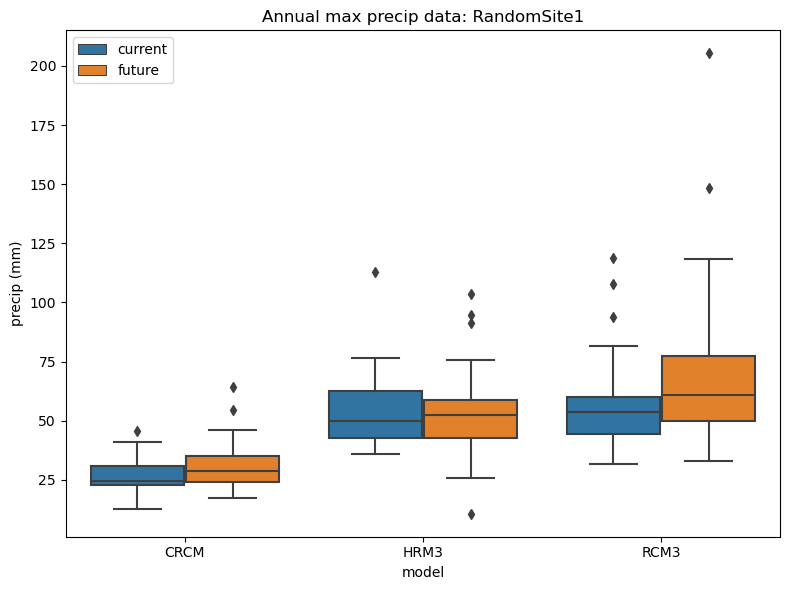

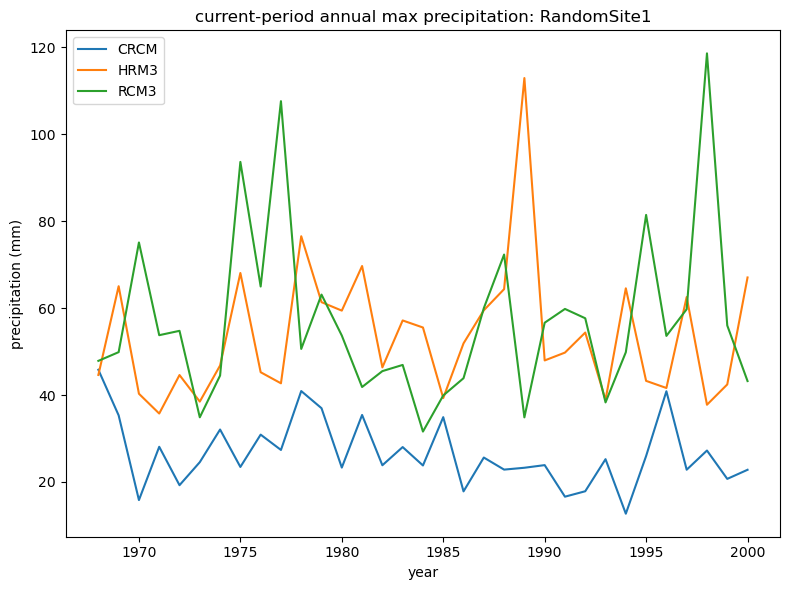

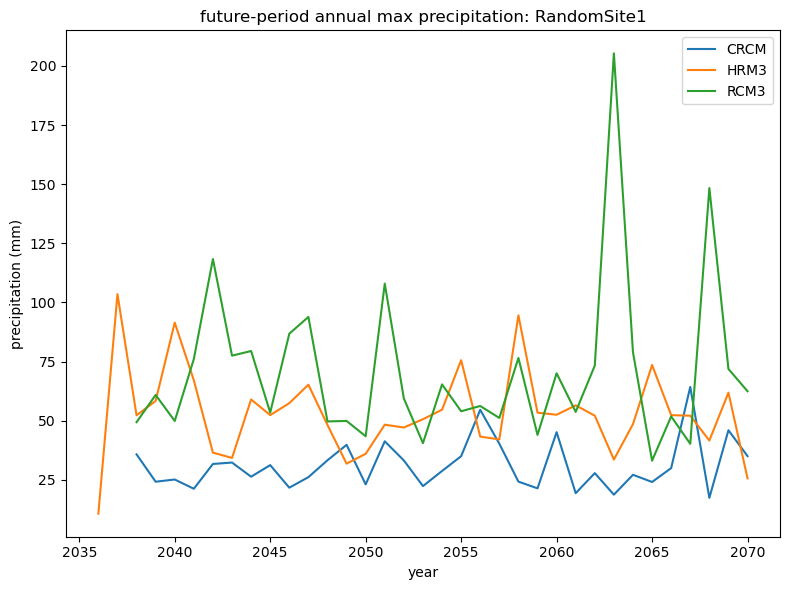

In [3]:
# =============================================================================
# #Relevant Imports
# =============================================================================
import pandas as pd
import numpy as np
import chrpa.main.processing as main
import os
import glob

# =============================================================================
# Loading lists from Part 1 above
# =============================================================================
climate_models = ['HRM3_gfdl', 'CRCM_ccsm', 'CRCM_cgcm3',
                  'HRM3_hadcm3', 'RCM3_cgcm3', 'RCM3_gfdl']
#climate_models = ['HRM3_gfdl', 'CRCM_ccsm','RCM3_cgcm3']

site_name = 'RandomSite1'

pkl_dir = 'pkl_data'
time_current_ser = pd.read_pickle(os.path.join(pkl_dir, site_name+'_timelistprecipcurrent_mods.pkl'))
precip_current_ser = pd.read_pickle(os.path.join(pkl_dir, site_name+'_preciplistcurrent_mods.pkl'))
time_future_ser = pd.read_pickle(os.path.join(pkl_dir, site_name+'_timelistprecipfuture_mods.pkl'))
precip_future_ser = pd.read_pickle(os.path.join(pkl_dir, site_name+'_preciplistfuture_mods.pkl'))

precip_stats_main = pd.DataFrame()
precipDF_AnnMax = pd.DataFrame()
for mymodel in climate_models:
# =============================================================================
# Creating Time-Weather Data Frames
# =============================================================================
    timelistprecip_current = time_current_ser[mymodel]
    preciplist_current = precip_current_ser[mymodel]
    timelistprecip_future = time_future_ser[mymodel]
    preciplist_future = precip_future_ser[mymodel]


# =============================================================================
#     Precipitation
# =============================================================================
    start_time1 = "1968-01-01 00:00:00"
    start_time2 = "2038-01-01 00:00:00" #used for converting all "future" time-deltas (as provided by the NARCCAP files), except for HRM3-based climate models which use start_time1

    wvar='precip'
    tint = 3 #hours
    tvar = 'time'

    timeprecipDF_current = main.timedelta_to_continuous_w_weather(timelistprecip_current,
                                                              preciplist_current,
                                                              wvar=wvar,
                                                              start_time=start_time1,
                                                              start_time_format="%Y-%m-%d %H:%M:%S",
                                                              td_unit='days')
    if 'HRM3' in mymodel:
        start_time_fut = start_time1
    else:
        start_time_fut = start_time2
    timeprecipDF_future = main.timedelta_to_continuous_w_weather(timelistprecip_future,
                                                             preciplist_future,
                                                             wvar=wvar,
                                                             start_time=start_time_fut,
                                                             start_time_format="%Y-%m-%d %H:%M:%S",
                                                             td_unit='days')

# =============================================================================
#     Converting precipitation data and creating data frames with daily data
# =============================================================================

    # Function below converts: (1) precip from kg/m^2-s to mm, and (2) the time/time-stamps to pure dates to aggregate daily data
    # Aggregating daily precip by summing
    #Note that time-stamps with NaNs are cleaned out of the data set here.
    aggfun='sum'
    precip_daily_current = main.convert_to_mm_daily(timeprecipDF_current, tint, tvar, wvar, aggfun)
    precip_daily_future = main.convert_to_mm_daily(timeprecipDF_future, tint, tvar, wvar, aggfun)

#=========================Temporary HACK for spikes in RCM3===================
    precip_daily_current=precip_daily_current[precip_daily_current.precip<500]
    precip_daily_future=precip_daily_future[precip_daily_future.precip<500]
#=======================End Temporary HACK====================================


    precip_stats_current, precip_stats_future = main.summary_stat_fun(precip_daily_current,
                                                                      precip_daily_future,
                                                                      mymodel,
                                                                      site_name)
    precip_stats_main = pd.concat([precip_stats_main,
                                   precip_stats_current,
                                   precip_stats_future],
                                  ignore_index=True)


# =============================================================================
#     Extracting Annual Extremes
# =============================================================================
    max_dict_rename_precip = {'precip':'MaxPrecip'}
    precipDF_current_AnnMax = main.get_annual_max(precip_daily_current,
                                                  max_dict_rename_precip,
                                                  mymodel,
                                                  'current')
    precipDF_future_AnnMax = main.get_annual_max(precip_daily_future,
                                                 max_dict_rename_precip,
                                                 mymodel,
                                                 'future')

    precipDF_AnnMax = pd.concat([precipDF_AnnMax,
                                 precipDF_current_AnnMax,
                                 precipDF_future_AnnMax],
                                ignore_index=True)

#-------Looping Ends
precip_stats_main = precip_stats_main.sort_values(by=['time_period', 'model'], ignore_index=True)
print(precip_stats_main)
precipDF_AnnMax.model = precipDF_AnnMax.model.apply(lambda x: x[:4])
precipDF_AnnMax_agg = precipDF_AnnMax.groupby(['model', 'period', 'year']).mean(numeric_only=True)
precipDF_AnnMax_agg.reset_index(inplace=True)


main.combined_boxplots(precipDF_AnnMax_agg, 'precip', site_name, 'plots')
main.line_plot(site_name, 'current', precipDF_AnnMax_agg[precipDF_AnnMax_agg.period=='current'], 'precip', 'plots', 'model')
main.line_plot(site_name, 'future', precipDF_AnnMax_agg[precipDF_AnnMax_agg.period=='future'], 'precip', 'plots', 'model')

